Playing around with: https://www.kaggle.com/code/teddykoker/training-cellular-automata-part-i-game-of-life/notebook

In [6]:
import time
import imageio

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output
from IPython.display import display, HTML
import IPython

import os
import pygame

ModuleNotFoundError: No module named 'pygame'

## Initial Conway's Game of Life

In [ ]:
train_size, width, height = (10, 32, 32)
device = torch.device("mps")

def gol(x):
    # performs one step of Conway's Game of Life
    # http://jakevdp.github.io/blog/2013/08/07/conways-game-of-life/
    nbrs_count = sum(np.roll(np.roll(x, i, 0), j, 1)
                     for i in (-1, 0, 1) for j in (-1, 0, 1)
                     if (i != 0 or j != 0))
    return (nbrs_count == 3) | (x & (nbrs_count == 2))


x_train = np.random.randint(0, 2, size=(train_size, width, height))
y_train = np.stack([gol(d) for d in x_train])
x_train = np.stack([1 - x_train, x_train], axis=1) # one channel per color

x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).to(device)

### Model

In [ ]:
class CircularPad(nn.Module):
    def forward(self, x):
        return F.pad(x, (1,1,1,1), mode='circular')

gol_model = nn.Sequential(
    CircularPad(),
    nn.Conv2d(2, 8, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(8, 8, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(8, 2, kernel_size=1),
).to(device)

### Training

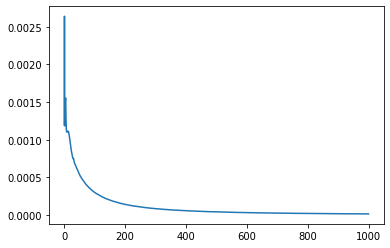

In [ ]:
num_epochs = 1000

optimizer = torch.optim.Adam(gol_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

losses = np.zeros(num_epochs)

for e in range(num_epochs):
    optimizer.zero_grad()
    y_pred = gol_model(x_train)
    loss = criterion(y_pred, y_train)
    losses[e] = loss.item()
    loss.backward()
    optimizer.step()

plt.plot(losses)

#### Test

In [ ]:
#Setup
glider = np.array([[0,1,0],
                   [0,0,1],
                   [1,1,1]])
state = np.zeros((32, 32))
state[:3,:3] = glider
state = np.stack([1 - state, state])
state = torch.from_numpy(state).float().unsqueeze(0).to(device)

NameError: name 'np' is not defined

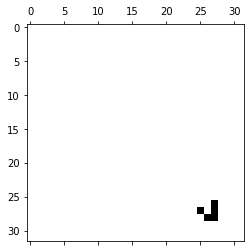

In [ ]:
#iterate
@torch.no_grad()
def animate(i):
    global state
    state = torch.softmax(gol_model(state), dim=1).to(device) #calculate new state
    mat.set_data(state.detach().cpu().numpy()[0,0]) #update the mat shown to reflect the new state

fig, ax = plt.subplots()
mat = ax.matshow(state.detach().cpu().numpy()[0,0], cmap="gray") #show mat in fig

IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=100, interval=100).to_jshtml())
#anim = animation.FuncAnimation(fig, animate, frames=100, interval=60)
#plt.show()

In [ ]:
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
#
#pix_size = 12
#_map_shape = (64,64)
#
#glider = np.array([[0,1,0],
#                   [0,0,1],
#                   [1,1,1]])
#state = np.zeros(_map_shape)
#state[:3,:3] = glider
#state = np.stack([1 - state, state])
#state = torch.from_numpy(state).float().unsqueeze(0).to(device)
#disp = displayer(_map_shape, pix_size)
#
#running = True
#while running:
#    for event in pygame.event.get():
#        if event.type == pygame.QUIT:
#            running = False
#
#    state = torch.softmax(gol_model(state), dim=1).to(device)
#    rgb = state.detach().cpu().numpy()[0,0]
#    _map = np.dstack((rgb, rgb, rgb)).astype(np.float32)
#    disp.update(_map)